In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices
from shapley.tests import ProductGaussian, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results, plot_error, plot_var

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [0, 1.0]

In [4]:
dim = 2
beta = None
model = ProductGaussian(dim=dim, beta=beta)
model.margins = [ot.Normal()]*dim
corr = 0.0
theta = [corr]
model.copula_parameters = theta

if True:
    dim = 3
    beta = None
    model = AdditiveGaussian(dim=dim, beta=beta)
    model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    corr = -0.6
    theta = [0., 0., corr]
    model.copula_parameters = theta
    
true_results = {
    'Shapley': model.shapley_indices,
    'First Sobol': model.first_sobol_indices,
    'Total Sobol': model.total_sobol_indices
}

In [5]:
Nv = 10000
n_perms = None

n_boot = 1
n_run = 30

if True:
    all_Ni = [10]
    n_Ni = len(all_Ni)
else:
    n_Ni = 3
    all_Ni = np.linspace(min_Ni, max_Ni, n_Ni, dtype=int)

if False:
    #all_No = np.asarray([1, 5])
    n_No = len(all_No)
else:
    n_No = 10
    min_No = 10
    max_No = 10000
    all_No = np.linspace(min_No, max_No, n_No, dtype=int)

In [6]:
ot.RandomGenerator.SetSeed(1)
np.random.seed(1)

all_shapley_results = np.zeros((n_No, n_Ni, n_run, dim, n_boot))
all_first_results = np.zeros((n_No, n_Ni, n_run, dim, n_boot))
all_total_results = np.zeros((n_No, n_Ni, n_run, dim, n_boot))
all_shapley_indices_SE = np.zeros((n_No, n_Ni, n_run, dim))
all_total_indices_SE = np.zeros((n_No, n_Ni, n_run, dim))
all_first_indices_SE = np.zeros((n_No, n_Ni, n_run, dim))

for i_No, No in enumerate(all_No):
    for i_Ni, Ni in enumerate(all_Ni):
        print('No:', No, 'Ni:', Ni)
        for i_run in range(n_run):
            shapley = ShapleyIndices(model.input_distribution)
            shapley.build_sample(model=model, n_perms=n_perms, n_var=Nv, n_outer=int(No), n_inner=int(Ni))
            shapley_results = shapley.compute_indices(n_boot=n_boot)
            all_shapley_results[i_No, i_Ni, i_run] = shapley_results.full_shapley_indices
            all_first_results[i_No, i_Ni, i_run] = shapley_results.full_first_indices
            all_total_results[i_No, i_Ni, i_run] = shapley_results.full_total_indices
            if n_perms is not None:
                all_shapley_indices_SE[i_No, i_Ni, i_run] = shapley_results.shapley_indices_SE[:, 0]
                all_total_indices_SE[i_No, i_Ni, i_run] = shapley_results.total_indices_SE[:, 0]
                all_first_indices_SE[i_No, i_Ni, i_run] = shapley_results.first_indices_SE[:, 0]

No: 10 Ni: 10
No: 1120 Ni: 10
No: 2230 Ni: 10
No: 3340 Ni: 10
No: 4450 Ni: 10
No: 5560 Ni: 10
No: 6670 Ni: 10
No: 7780 Ni: 10
No: 8890 Ni: 10
No: 10000 Ni: 10


/home/D58174/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


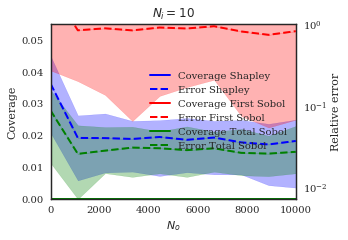

In [21]:
# Coverage probability
alpha = 0.05
legend = False
absolute_error = False
name = 'N_o'

if name == 'N_i':
    x = all_Ni 
    x_c = all_No
    name_c = 'N_o'
    axis = 0
else:
    x = all_No
    x_c = all_Ni
    name_c = 'N_i'
    axis = 1

n = len(x_c)
if n > 3:
    assert n == 6, "Only works with n=6"
    fig, axes = plt.subplots(2, int(n/2), figsize=(2*3+3, 6), sharex=True, sharey=True)
    lvl = 2
else:
    fig, axes = plt.subplots(1, n, figsize=(2*n+3, 3.5), sharex=True, sharey=True) 
    lvl = 1
    
if n == 1:
    axix = [axes]
else:
    axix = axes.ravel()
for i, (N, ax) in enumerate(zip(x_c, axix)):
    results = {
        'Shapley': all_shapley_results.take(i, axis=axis),
        'First Sobol': all_first_results.take(i, axis=axis),
        'Total Sobol': all_total_results.take(i, axis=axis)
    }
    results_SE = {
        'Shapley': all_shapley_indices_SE.take(i, axis=axis),
        'First Sobol': all_first_indices_SE.take(i, axis=axis),
        'Total Sobol': all_total_indices_SE.take(i, axis=axis)
    }
    if i == n-1:
        legend = True
        
    ax, ax2 = plot_error(results, x, true_results, n_perms=n_perms, results_SE=results_SE, ax=ax, ylim=[0., None], alpha=alpha, loc=5, 
                         logscale=True, legend=legend, absolute_error=absolute_error)
    
    if lvl == 1:
        ax.set_xlabel('$%s$' % (name))
        if i < n-1:
            ax2.set_ylabel('')
            ax2.set_yticks([])
        if i > 0:
            ax.set_ylabel('')
    else:
        if i != 2 and i != n-1:
            ax2.set_ylabel('')
        if i != 0 and i != 3:
            ax.set_ylabel('')
        if 2 < i <= n-1:
            ax.set_xlabel('$%s$' % (name))
        else:
            ax.set_xlabel('') 
        
    ax.plot(ax.get_xlim(), [1. - alpha]*2, '-.')
    ax.set_title('$%s = %d$' % (name_c, N))
    
fig.tight_layout()
if savefigs:
    fig.savefig('./output/gaussian_precision_nNo_%d_nNi_%d_rho_%.2f_Nv_%d_maxNo_%d_maxNi_%d_nrun%d_absolute%d.pdf' % (n_No, n_Ni, corr, Nv, max_No, max_Ni, n_run, absolute_error))

In [ ]:
legend = False
if n > 3:
    assert n == 6, "Only works with n=6"
    fig, axes = plt.subplots(2, int(n/2), figsize=(2*3+3, 6), sharex=True, sharey=True)
    lvl = 2
else:
    fig, axes = plt.subplots(1, n, figsize=(2*n+3, 3.5), sharex=True, sharey=True) 
    lvl = 1
    
for i, (N, ax) in enumerate(zip(x_c, axes.ravel())):
    results = {
        'Shapley': all_shapley_results.take(i, axis=axis),
        'First Sobol': all_first_results.take(i, axis=axis),
        'Total Sobol': all_total_results.take(i, axis=axis)
    }
    if i == n-1:
        legend = True
        
    ax = plot_var(results, x, ax=ax, ylim=[0, 1], alpha=alpha, loc=0, logscale=False, legend=legend)
    
    if lvl == 1:
        ax.set_xlabel('$%s$' % (name))
        if i > 0:
            ax.set_ylabel('')
    else:
        if i != 0 and i != 3:
            ax.set_ylabel('')
        if 2 < i <= n-1:
            ax.set_xlabel('$%s$' % (name))
        else:
            ax.set_xlabel('')  
    
    fig.tight_layout()
    ax.set_title('$%s = %d$' % (name_c, N))
    if savefigs:
        fig.savefig('./output/var_gaussian_precision_nNo_%d_rho_%.2f_Nv_%d_maxNo_%d_maxNi_%d_nrun%d.pdf' % (n_No, corr, Nv, max_No, max_Ni, n_run))